## Hidden Markov Model in Pytorch

### Tutorial Includes:
#### Viterbi Algorithm
        Maximum a Posteri

#### Forward-Backward Algorithm
        Posterior Marginals

#### Baum Welch Algorithm
        Expectation Maximization Inference

### HMM Fundamentals

#### HMM recap:
    •	Undirected graphical model.
    •	Connections between nodes indicate dependence.
    •	We observe Y1 through Yn, which we model as being observed from hidden states S1 through Sn.
    •	Any particular state variable Sk depends only on Sk−1 (what came before it), Sk+1 (what comes after it), and Yk (the observation associated with it).

#### HMM are specified by three sets of parameters
####    •	Transition distribution:
        	describes the distribution for the next state given the current state.
        	P(nextState|currentState)

####    •	Emission distribution:
        	describes the distribution for the output given the current state.
        	P(Observation|currentState)

####    •	Initial state distribution:
        	describes the starting distribution over states.
        	P(initialState)

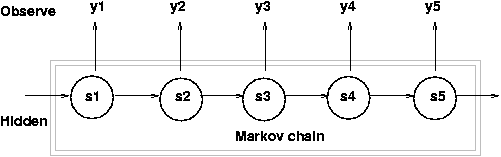

### State Transitions

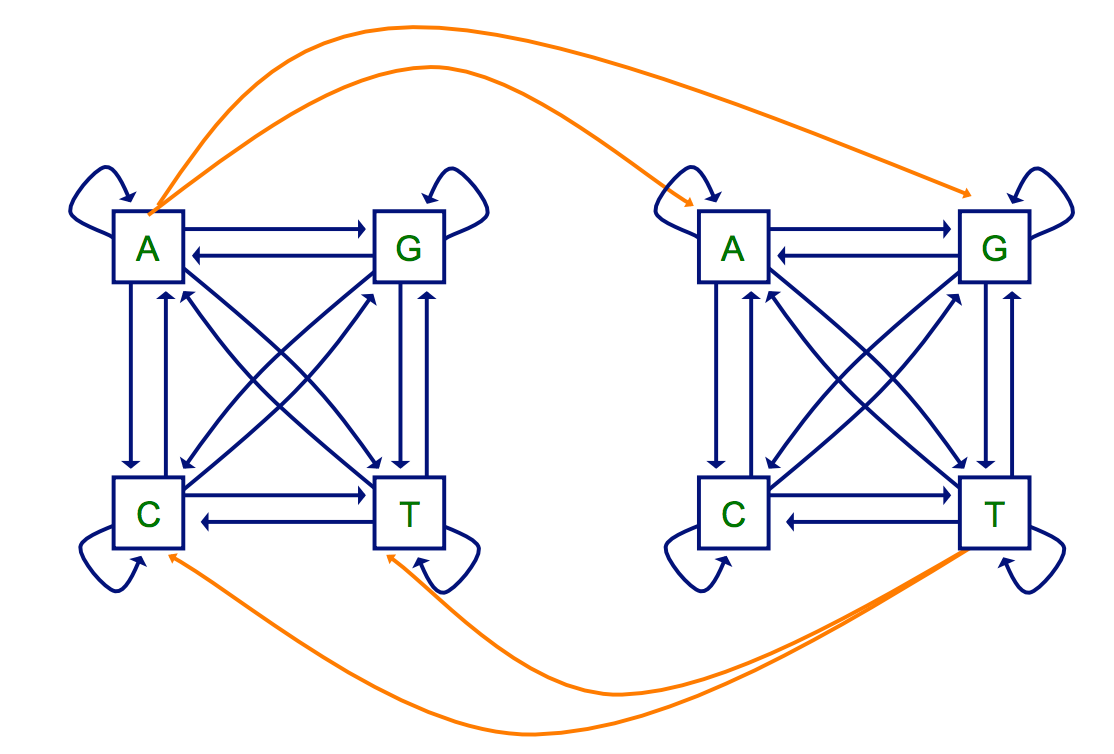



### Viterbi Algorithm
    •	Efficient way of finding the most likely state sequence.
    •	Method is general statistical framework of compound decision theory.
    •	Maximizes a posteriori probability recursively.
    •	Assumed to have a finite-state discrete-time Markov process.

#### Maximum a posteri (MAP) probability, given by:
#####                                       P(States|Observations)=P(Observations)|States)P(States)P(Observations)

Given a hidden Markov model (HMM) with:
    •	State space S
    •	Initial probabilities πi of being in state i
    •	Transition probabilities ai,j of transitioning from state i to state j.
    •	We observe outputs y1,…, yT.
    •	The most likely state sequence x1,…,xT that produces the observations is given by the recurrence relations:
#####                                        V1,k=P(y1|k)⋅πk
#####                                        Vt,k=maxx(P(yt|k)⋅ax,k⋅Vt−1,x
    •	Vt,k is the probability of the most probable state sequence P(x1,…,xT,y1,…,yT)
    •	The Viterbi path can be retrieved by saving back pointers that remember which state x was used in the second equation.
    •	Let Ptr(k,t) be the function that returns the value of x used to compute Vt,k if t>1, or k if t=1. Then:
xT=argmaxx(VT,x)xt−1=Ptr(xt,t)

### Shortest Route Task

The MAP sequence estimation problem previously stated can also be viewed as the problem of finding the shortest route through a certain graph.
#### Representing an HMM as a trellis
    •	Each node corresponds to a distinct state at a given time
    •	Each arrow represents a transition to some new state at the next instant of time.
    •	The trellis begins and ends at the known states c0 and cn.
    •	Its most important property is that to every possible state sequence C there corresponds a unique path through the trellis, and vice versa.

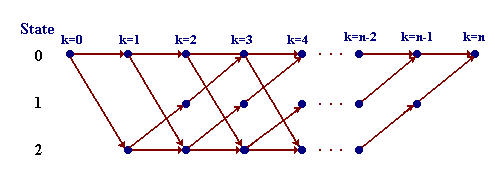

    •	Assign to every path a length proportional to −log[p(Observations)|States)+P(States)].
    •	log() is a monotonic function and there is a one-to-one correspondence between paths and sequences, we only need to find the path whose −log[p(Observations)|States)+P(States)] is minimum.
    •	This will give us the state sequence for which p(Observations)|States)⋅P(States) is maximum.
    •	This is the state sequence with the maximum a posteriori (MAP) probability.

#### Graph Search

Four-state trellis covering five time units.
 
#### Recursive Steps
The 5 recursive steps by which the algorithm determines the shortest path from the initial to the final node are shown in here. At each step only the 4 (or fewer) survivors are shown, along with their lengths.

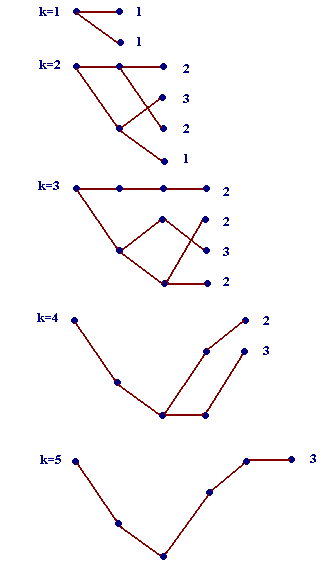

In [1]:
### Importing the libraries
import torch
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def dptable(state_prob):
    print(" ".join(("%8d" % i) for i in range(state_prob.shape[0])))
    for i, prob in enumerate(state_prob.T):
        print("%.7s: " % states[i] +" ".join("%.7s" % ("%f" % p) for p in prob))

In [3]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

### Let's create the HiddenMarkovModel function

In [15]:
import torch
import numpy as np
import pdb

class HiddenMarkovModel(object):
    """
    Hidden Markov self Class
    Parameters:
    -----------
    
    - S: Number of states.
    - T: numpy.array Transition matrix of size S by S
         stores probability from state i to state j.
    - E: numpy.array Emission matrix of size S by N (number of observations)
         stores the probability of observing  O_j  from state  S_i. 
    - T0: numpy.array Initial state probabilities of size S.
    """

    def __init__(self, T, E, T0, epsilon = 0.001, maxStep = 10):
        # Max number of iteration
        self.maxStep = maxStep
        # convergence criteria
        self.epsilon = epsilon 
        # Number of possible states
        self.S = T.shape[0]
        # Number of possible observations
        self.O = E.shape[0]
        self.prob_state_1 = []
        # Emission probability
        self.E = torch.tensor(E)
        # Transition matrix
        self.T = torch.tensor(T)
        # Initial state vector
        self.T0 = torch.tensor(T0)
        
    def initialize_viterbi_variables(self, shape): 
        pathStates = torch.zeros(shape, dtype=torch.float64)
        pathScores = torch.zeros_like(pathStates)
        states_seq = torch.zeros([shape[0]], dtype=torch.int64)
        return pathStates, pathScores, states_seq
    
    def belief_propagation(self, scores):
        return scores.view(-1,1) + torch.log(self.T)
    
    def viterbi_inference(self, x): # x: observing sequence        
        self.N = len(x)
        shape = [self.N, self.S]
        # Init_viterbi_variables
        pathStates, pathScores, states_seq = self.initialize_viterbi_variables(shape) 
        # log probability of emission sequence
        obs_prob_full = torch.log(self.E[x])
        # initialize with state starting log-priors
        pathScores[0] = torch.log(self.T0) + obs_prob_full[0]
        for step, obs_prob in enumerate(obs_prob_full[1:]):
            # propagate state belief
            belief = self.belief_propagation(pathScores[step, :])
            # the inferred state by maximizing global function
            pathStates[step + 1] = torch.argmax(belief, 0)
            # and update state and score matrices 
            pathScores[step + 1] = torch.max(belief, 0)[0] + obs_prob
        # infer most likely last state
        states_seq[self.N - 1] = torch.argmax(pathScores[self.N-1, :], 0)
        for step in range(self.N - 1, 0, -1):
            # for every timestep retrieve inferred state
            state = states_seq[step]
            state_prob = pathStates[step][state]
            states_seq[step -1] = state_prob
        return states_seq, torch.exp(pathScores) # turn scores back to probabilities
    
    def initialize_forw_back_variables(self, shape):
        self.forward = torch.zeros(shape, dtype=torch.float64)
        self.backward = torch.zeros_like(self.forward)
        self.posterior = torch.zeros_like(self.forward)
        
    def _forward(model, obs_prob_seq):
        model.scale = torch.zeros([model.N], dtype=torch.float64) #scale factors
        # initialize with state starting priors
        init_prob = model.T0 * obs_prob_seq[0]
        # scaling factor at t=0
        model.scale[0] = 1.0 / init_prob.sum()
        # scaled belief at t=0
        model.forward[0] = model.scale[0] * init_prob
         # propagate belief
        for step, obs_prob in enumerate(obs_prob_seq[1:]):
            # previous state probability
            prev_prob = model.forward[step].unsqueeze(0)
            # transition prior
            prior_prob = torch.matmul(prev_prob, model.T)
            # forward belief propagation
            forward_score = prior_prob * obs_prob
            forward_prob = torch.squeeze(forward_score)
            # scaling factor
            model.scale[step + 1] = 1 / forward_prob.sum()
            # Update forward matrix
            model.forward[step + 1] = model.scale[step + 1] * forward_prob
    
    def _backward(self, obs_prob_seq_rev):
        # initialize with state ending priors
        self.backward[0] = self.scale[self.N - 1] * torch.ones([self.S], dtype=torch.float64)
        # propagate belief
        for step, obs_prob in enumerate(obs_prob_seq_rev[:-1]):
            # next state probability
            next_prob = self.backward[step, :].unsqueeze(1)
            # observation emission probabilities
            obs_prob_d = torch.diag(obs_prob)
            # transition prior
            prior_prob = torch.matmul(self.T, obs_prob_d)
            # backward belief propagation
            backward_prob = torch.matmul(prior_prob, next_prob).squeeze()
            # Update backward matrix
            self.backward[step + 1] = self.scale[self.N - 2 - step] * backward_prob
        self.backward = torch.flip(self.backward, [0, 1])
        
    def forward_backward(self, obs_prob_seq):
        """
        runs forward backward algorithm on observation sequence
        Arguments
        ---------
        - obs_prob_seq : matrix of size N by S, where N is number of timesteps and
            S is the number of states
        Returns
        -------
        - forward : matrix of size N by S representing
            the forward probability of each state at each time step
        - backward : matrix of size N by S representing
            the backward probability of each state at each time step
        - posterior : matrix of size N by S representing
            the posterior probability of each state at each time step
        """        
        self._forward(obs_prob_seq)
        obs_prob_seq_rev = torch.flip(obs_prob_seq, [0, 1])
        self._backward(obs_prob_seq_rev)
    
    def re_estimate_transition(self, x):
        self.M = torch.zeros([self.N - 1, self.S, self.S], dtype = torch.float64)

        for t in range(self.N - 1):
            tmp_0 = torch.matmul(self.forward[t].unsqueeze(0), self.T)
            tmp_1 = tmp_0 * self.E[x[t + 1]].unsqueeze(0)
            denom = torch.matmul(tmp_1, self.backward[t + 1].unsqueeze(1)).squeeze()

            trans_re_estimate = torch.zeros([self.S, self.S], dtype = torch.float64)

            for i in range(self.S):
                numer = self.forward[t, i] * self.T[i, :] * self.E[x[t+1]] * self.backward[t+1]
                trans_re_estimate[i] = numer / denom

            self.M[t] = trans_re_estimate

        self.gamma = self.M.sum(2).squeeze()
        T_new = self.M.sum(0) / self.gamma.sum(0).unsqueeze(1)

        T0_new = self.gamma[0,:]

        prod = (self.forward[self.N-1] * self.backward[self.N-1]).unsqueeze(0)
        s = prod / prod.sum()
        self.gamma = torch.cat([self.gamma, s], 0)
        self.prob_state_1.append(self.gamma[:, 0]) 
        return T0_new, T_new
    
    def re_estimate_emission(self, x):
        states_marginal = self.gamma.sum(0)
        # One hot encoding buffer that you create out of the loop and just keep reusing
        seq_one_hot = torch.zeros([len(x), self.O], dtype=torch.float64)
        seq_one_hot.scatter_(1, torch.tensor(x).unsqueeze(1), 1)
        emission_score = torch.matmul(seq_one_hot.transpose_(1, 0), self.gamma)
        return emission_score / states_marginal
    
    def check_convergence(self, new_T0, new_transition, new_emission):
  
        delta_T0 = torch.max(torch.abs(self.T0 - new_T0)).item() < self.epsilon
        delta_T = torch.max(torch.abs(self.T - new_transition)).item() < self.epsilon
        delta_E = torch.max(torch.abs(self.E - new_emission)).item() < self.epsilon

        return delta_T0 and delta_T and delta_E
    
    def expectation_maximization_step(self, obs_seq):
    
        # probability of emission sequence
        obs_prob_seq = self.E[obs_seq]

        self.forward_backward(obs_prob_seq)

        new_T0, new_transition = self.re_estimate_transition(obs_seq)

        new_emission = self.re_estimate_emission(obs_seq)

        converged = self.check_convergence(new_T0, new_transition, new_emission)
        
        self.T0 = new_T0
        self.E = new_emission
        self.T = new_transition
        
        return converged
    
    def Baum_Welch_EM(self, obs_seq):
        # length of observed sequence
        self.N = len(obs_seq)

        # shape of Variables
        shape = [self.N, self.S]

        # initialize variables
        self.initialize_forw_back_variables(shape)

        converged = False

        for i in range(self.maxStep):
            converged = self.expectation_maximization_step(obs_seq)
            if converged:
                print('converged at step {}'.format(i))
                break      
        return self.T0, self.T, self.E, converged

### Viterbi Example

Let's consider the following simple HMM.

    Composed of 2 hidden states: Healthy and Fever.
    Composed of 3 possible observation: Normal, Cold, Dizzy
The model can then be used to predict if a person is feverish at every timestep from a given observation sequence. There are several paths through the hidden states (Healthy and Fever) that lead to the given sequence, but they do not have the same probability.

The Viterbi algorithm is a dynamical programming algorithm that allows us to compute the most probable path. This package will compute recursively the probability of the most probable path.

Note: for the calculations, it is convenient to use the log of the probabilities. Indeed, this allows us to compute sums instead of products, which is more efficient and accurate.

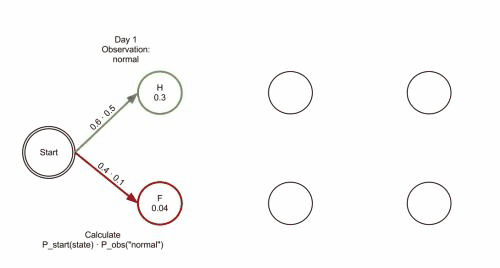

#### Model Parameters

In [16]:
p0 = np.array([0.6, 0.4])

emi = np.array([[0.5, 0.1],
                [0.4, 0.3],
                [0.1, 0.6]])

trans = np.array([[0.7, 0.3],
                  [0.4, 0.6]])

states = {0:'Healthy', 1:'Fever'}
obs = {0:'normal', 1:'cold', 2:'dizzy'}

obs_seq = np.array([0, 0, 1, 2, 2])

In [17]:
df_p0 = pd.DataFrame(p0, index=["Healthy", "Fever"], columns=["Prob"])
df_emi = pd.DataFrame(emi, index=["Normal", "Cold", "Dizzy"], columns=["Healthy", "Fever"])
df_trans = pd.DataFrame(trans, index=["fromHealthy", "fromFever"], columns=["toHealthy", "toFever"])

#### Inital state probability

In [18]:
df_p0

,Prob
Healthy,0.6
Fever,0.4


#### Transition Probability Matrix

In [19]:
df_trans

,toHealthy,toFever
fromHealthy,0.7,0.3
fromFever,0.4,0.6


#### Emission Probability Matrix

In [20]:
df_emi

,Healthy,Fever
Normal,0.5,0.1
Cold,0.4,0.3
Dizzy,0.1,0.6


### Run Viterbi

In [21]:
model =  HiddenMarkovModel(trans, emi, p0)

states_seq, state_prob = model.viterbi_inference(obs_seq)

print("Observation sequence: ", [obs[o] for o in obs_seq])
df = pd.DataFrame(torch.t(state_prob).cpu().numpy(), index=["Healthy", "Fever"])
df.style.apply(highlight_max, axis=0)

Observation sequence:  ['normal', 'normal', 'cold', 'dizzy', 'dizzy']


,0,1,2,3,4
Healthy,0.300000,0.105000,0.029400,0.002058,0.000212
Fever,0.040000,0.009000,0.009450,0.005292,0.001905


In [22]:
print("Most likely States: ",[states[s.item()] for s in states_seq])

Most likely States:  ['Healthy', 'Healthy', 'Healthy', 'Fever', 'Fever']


### Forward - Backward Algorithm

### Overview
    •	The goal of the forward-backward algorithm is to find the conditional distribution over hidden states given the data.
    •	It is used to find the most likely state for any point in time.
    •	It cannot, however, be used to find the most likely sequence of states (see Viterbi)

### The forward–backward algorithm:
    •	Inference algorithm for hidden Markov models.
    •	Computes posterior marginals of all hidden state variables given a sequence of observations/emissions.
    •	Computes, for all hidden state variables Sk∈{S1,…,St}, the distribution P(Sk | o1:t).
    •	This inference task is usually called smoothing.
    •	The algorithm makes use of the principle of dynamic programming to compute efficiently the values that are required to obtain the posterior marginal distributions in two passes.
    •	The first pass goes forward in time while the second goes backward in time.

### Visualization of the Forward and Backward Messages
    •	Each message is a table that indicates what the node at the start point believes about the node at the end point.
    
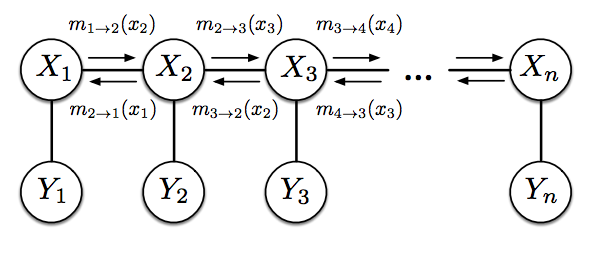    



### Computing Message Passing

#### Forward message
    •	αk represents a message from k−1 to k that includes pY|X(yk|xk).
#### Backward message
    •	βk represents a message from k+1 to k.
    
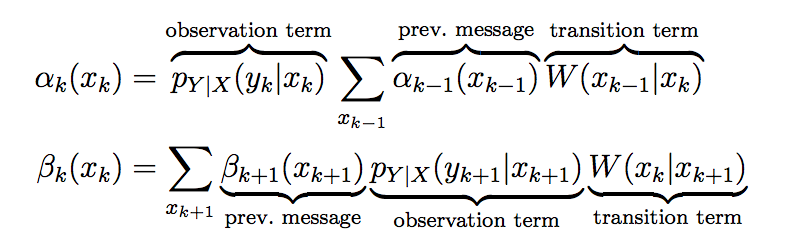





### Probability interpretation of message passing
#### Forward message
    •	The probability of ending up in any particular state given the first k observations in the sequence.
#### Backward message
    •	The probability of observing the remaining observations given any starting point k

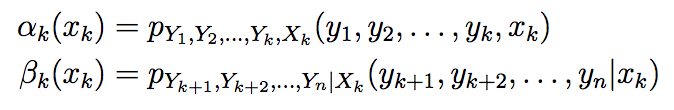

### Smoothing Step
### Represent the conditional probability of being in state Si at time t given the observation sequence
    •	The initial forward α message is initialized to α1(x1)=PX1(x1)PY|X(y1|x1).
    •	To obtain a marginal distribution, we simply multiply the messages together and normalize:
    •	The smoothing step allows the algorithm to take into account any past observations of output for computing more accurate results.


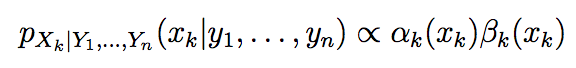

### Visualizing Message Passing for m2→3(x3)
#### In order for node 2 to summarize its belief about X3, it must incorporate:
    •	The previous message m1→2(x2)
    •	Its observation pY|X(y2|x2)
    •	The relationship W(x3|x2) between X2 and X3.

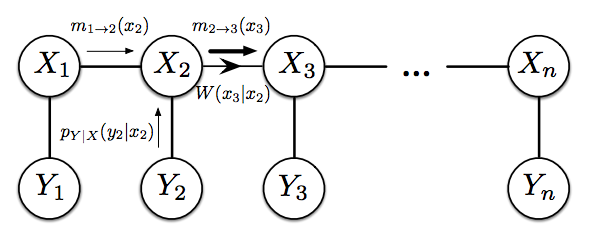

### Forward-Backward Example
Let's condiser a situation where you work in a shopping mall with no views to the outside. You wish to infer the weather outside (Rain, No Rain) at the present moment, given only obervations of passerby with or without an umbrella.

#### Define Model Parameters

In [23]:
p0 = np.array([0.5, 0.5])

emi = np.array([[0.9, 0.2],
                [0.1, 0.8]])

trans = np.array([[0.7, 0.3],
                  [0.3, 0.7]])

states = {0:'rain', 1:'no_rain'}
obs = {0:'umbrella', 1:'no_umbrella'}

obs_seq = np.array([1, 1, 0, 0, 0, 1])

#### Run Forward-Backward

In [24]:
model =  HiddenMarkovModel(trans, emi, p0)

In [25]:
model.N = len(obs_seq)

shape = [model.N, model.S]

In [26]:
model.initialize_forw_back_variables(shape)

In [27]:
obs_prob_seq = model.E[obs_seq]

In [28]:
model.forward_backward(obs_prob_seq)

In [29]:
posterior = model.forward * model.backward

# marginal per timestep
marginal = torch.sum(posterior, 1)
        
# Normalize porsterior into probabilities
posterior = posterior / marginal.view(-1, 1)

In [30]:
results = [model.forward.cpu().numpy(), model.backward.cpu().numpy(), posterior.cpu().numpy()]
result_list = ["Forward", "Backward", "Posterior"]

for state_prob, path in zip(results, result_list) :
    inferred_states = np.argmax(state_prob, axis=1)
    print()
    print(path)
    dptable(state_prob)
    print()

print("="*60)
print("Most likely Final State: ",states[inferred_states[-1]])
print("="*60)


Forward
       0        1        2        3        4        5
rain: 0.11111 0.06163 0.68386 0.85819 0.89029 0.19256
no_rain: 0.88888 0.93837 0.31613 0.14180 0.10971 0.80743


Backward
       0        1        2        3        4        5
rain: 1.40699 3.23616 2.72775 1.73108 1.39911 2.93497
no_rain: 2.32412 1.69423 1.50282 1.24784 2.66283 2.93497


Posterior
       0        1        2        3        4        5
rain: 0.07035 0.11146 0.79701 0.89357 0.81002 0.19256
no_rain: 0.92965 0.88853 0.20298 0.10643 0.18997 0.80743

Most likely Final State:  no_rain


### Baum Welch Algorithm
Baum–Welch algorithm is used to infer unknown parameters of a Hidden Markov Model.
#### Model Parameters:
    •	Initial State Probabilities
    •	Transition Matrix
    •	Emission Matrix

#### Expectation-Maximization
It makes use of the forward-backward algorithm to update the hypothesis.

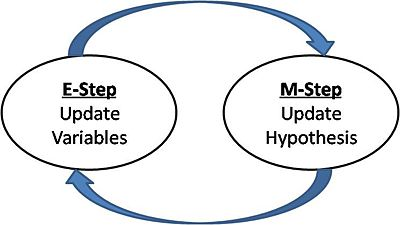

### Visualizing Expectation-Maximization

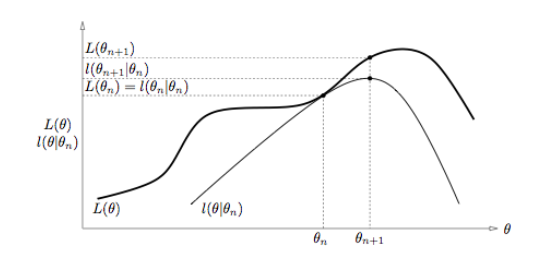



### Compute Variable Updates (Expectation step)
#### Calculate the temporary variables, according to Bayes' theorem:
It's the probability of being in state i at time t given the observed sequence Y and the parameters θ

γi(t)=P(Xt=i|Y,θ)=αi(t)βi(t)∑j=1Nαj(t)βj(t)

The probability of being in state i and j at times t and t+1 respectively given the observed sequence Y and parameters θ.

ξij(t)=P(Xt=i,Xt+1=j|Y,θ)=αi(t)aijβj(t+1)bj(yt+1)∑k=1Nαk(T)

#### Update Inital State Probability
It's expected frequency spent in state i at time 1.

πi∗=γi(1)

#### Update Transition Matrix
It's the expected number of transitions from state i to state j compared to the expected total number of transitions away from state i.

aij∗=∑t=1T−1ξij(t)∑t=1T−1γi(t)

#### Update Emission Matrix
It's the expected number of times the output observations have been equal to vk while in state i over the expected total number of times in state i.

bi∗(vk)=∑t=1T1yt=vkγi(t)∑t=1Tγi(t)

#### Note:
    •	It is possible to over-fit a particular data set. That is P(Y|θfinal)>P(Y|θtrue).
    •	The algorithm also does not guarantee a global maximum.

### Run Baum-Welch




#### Data Generator Function

In [31]:
def generate_HMM_observation(num_obs, pi, T, E):
    def drawFrom(probs):
        return np.where(np.random.multinomial(1,probs) == 1)[0][0]

    obs = np.zeros(num_obs)
    states = np.zeros(num_obs)
    states[0] = drawFrom(pi)
    obs[0] = drawFrom(E[:, int(states[0])])
    for t in range(1,num_obs):
        states[t] = drawFrom(T[int(states[t-1]),:])
        obs[t] = drawFrom(E[:, int(states[t])])
    return np.int64(obs), states

#### True Parameters that Generated the data

In [32]:
True_pi = np.array([0.5, 0.5])

True_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

True_E = np.array([[0.8, 0.0],
                   [0.1, 0.0],
                   [0.1, 1.0]])

#### Generate a Sample of 50 Observations

In [33]:
obs_seq, states = generate_HMM_observation(200, True_pi, True_T, True_E)

In [34]:
print("First 10 Obersvations:  ", obs_seq[:10])
print("First 10 Hidden States: ", states[:10])

First 10 Obersvations:   [0 0 0 0 0 1 0 1 2 2]
First 10 Hidden States:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [35]:
# obs_seq = np.array([2, 2, 2, 2, 0, 1, 1, 2, 0, 0], dtype=np.int64)
# states = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0.])

#### Initialize to Arbitrary Parameters

In [36]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.5, 0.5],
                  [0.5, 0.5]])

init_E = np.array([[0.3, 0.2],
                   [0.3, 0.5],
                   [0.4, 0.3]])

#### Train Model

In [37]:
model =  HiddenMarkovModel(init_T, init_E, init_pi, epsilon=0.0001, maxStep=100)

In [38]:
trans0, transition, emission, converge = model.Baum_Welch_EM(obs_seq)

print("Transition Matrix: ")
print(transition)
print()
print("Emission Matrix: ")
print(emission)
print()
print("Reached Convergence: ")
print(converge)

converged at step 57
Transition Matrix: 
tensor([[0.8722, 0.1278],
        [0.0834, 0.9166]], dtype=torch.float64)

Emission Matrix: 
tensor([[7.8899e-01, 7.0414e-04],
        [1.2593e-01, 2.3840e-12],
        [8.5080e-02, 9.9930e-01]], dtype=torch.float64)

Reached Convergence: 
True


### Plot of Probability of State 1 over multiple training steps

In [39]:
state_summary = np.array([model.prob_state_1[i].cpu().numpy() for i in range(len(model.prob_state_1))])

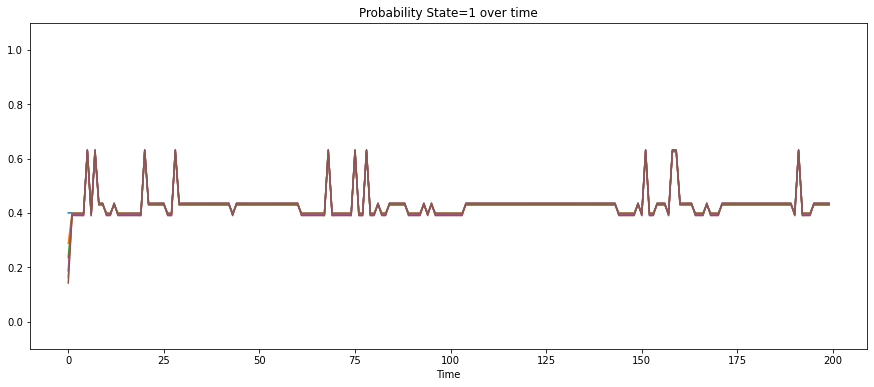

In [40]:
plt.figure(figsize=(15,6))
plt.plot(1 - state_summary[[0, 4, 6, 8, 9, 10]].T)
plt.ylim(-0.1,1.1)
plt.title('Probability State=1 over time')
plt.xlabel('Time')
plt.draw()

### Plot of True State over Guess Probability of State=1

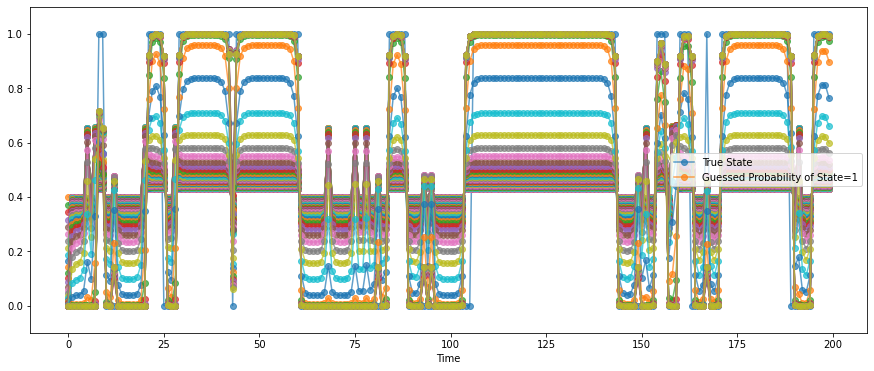

In [41]:
plt.figure(figsize=(15,6))
plt.plot(states.T,'-o',alpha=0.7)
plt.plot(1 - state_summary.T, '-o',alpha=0.7)
plt.legend(('True State','Guessed Probability of State=1'), loc = 'right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()

### Beware of Overfitting
    •	The algorithm is clearly learning to generate the correct hidden state.
    •	Baum Welch does, however, overfit quickly.
    •	It is important to:
            	Train on multiple sequences.
            	Regularize training.
            	Repeat inference with multiple random initial parameters.



In [42]:
pred = (1 - state_summary[-2]) > 0.5
print("Accuracy: ", np.mean(pred == states))

Accuracy:  0.97
